In [56]:
import pandas as pd
import os

os.chdir("C:\\Users\\gokul\\Documents\\learning\\practise problem\\airbnb\\Reviews and listings")
reviews = pd.read_csv("reviews.csv").head(3000)

reviews.info()
reviews.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 6 columns):
listing_id       3000 non-null int64
id               3000 non-null int64
date             3000 non-null object
reviewer_id      3000 non-null int64
reviewer_name    3000 non-null object
comments         2998 non-null object
dtypes: int64(3), object(3)
memory usage: 140.7+ KB


,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...


In [57]:
#dropping the empty rows
reviews.dropna(inplace=True)
reviews.info()

#removing the trailing and leading space
reviews['comments'] = reviews['comments'].str.strip()

#removing the special cahracters
reviews['comments'] = reviews['comments'].str.replace("[^a-zA-Z#]", " ")

#lower case
reviews['comments'] = reviews['comments'].apply(lambda x: x.lower())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2998 entries, 0 to 2999
Data columns (total 6 columns):
listing_id       2998 non-null int64
id               2998 non-null int64
date             2998 non-null object
reviewer_id      2998 non-null int64
reviewer_name    2998 non-null object
comments         2998 non-null object
dtypes: int64(3), object(3)
memory usage: 164.0+ KB


In [58]:
#token the word
import nltk

reviews['comments_token']= reviews['comments'].apply(lambda x: x.split())
reviews['comments_token'].head(3)


0    [my, stay, at, islam, s, place, was, really, c...
1    [great, location, for, both, airport, and, cit...
2    [we, really, enjoyed, our, stay, at, islams, h...
Name: comments_token, dtype: object

In [59]:
#lemma
from nltk.stem.wordnet import WordNetLemmatizer
def split_lemma(comments):
    lemma = []
    lemmatizer = WordNetLemmatizer()
    for word in comments:
        a=lemmatizer.lemmatize(word)
        lemma.append(a)
    return lemma

reviews['comments_token_lem']=reviews.apply(lambda row:split_lemma(row['comments_token']), axis=1)

reviews['comments_token_lem'].head(3)

0    [my, stay, at, islam, s, place, wa, really, co...
1    [great, location, for, both, airport, and, cit...
2    [we, really, enjoyed, our, stay, at, islam, ho...
Name: comments_token_lem, dtype: object

In [68]:
#visualize the word in wordmap reviews['comments_token_lem']

reviews['comments_token_lem'] = reviews['comments_token_lem'].apply(lambda x: ', '.join(x))

all_words = ' '.join([text for text in reviews['comments_token_lem']])
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

ModuleNotFoundError: No module named 'wordcloud'

In [69]:
# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [88]:

# extracting hashtags from non racist/sexist

HT_regular = hashtag_extract(reviews['comments_token_lem'][reviews['id'] == 0])

# extracting hashtags from racist/sexist tweets
HT_negative = hashtag_extract(reviews['comments_token_lem'][reviews['id'] == 1])

# unnesting list
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])

In [91]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'comments': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5))
plt.show()
ax = sns.barplot(data=d, x= "comments", y = "Count")
ax.set(ylabel = 'Count')


ValueError: min() arg is an empty sequence

In [95]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
for sentence in reviews['comments'].values[:5]:
    print (sentence)
    ss = sid.polarity_scores(sentence)
    for k in sorted(ss):
        print ('{0}: {1}, '.format(k, ss[k]))
    print()

my stay at islam s place was really cool  good location   min away from subway  then   min from downtown  the room was nice  all place was clean  islam managed pretty well our arrival  even if it was last minute    i do recommand this place to any airbnb user   
compound: 0.939, 
neg: 0.0, 
neu: 0.707, 
pos: 0.293, 

great location for both airport and city   great amenities in the house  plus islam was always very helpful even though he was away
compound: 0.9061, 
neg: 0.0, 
neu: 0.639, 
pos: 0.361, 

we really enjoyed our stay at islams house  from the outside the house didn t look so inviting but the inside was very nice  even though islam himself was not there everything was prepared for our arrival  the airport t station is only a      min walk away  the only little issue was that all the people in the house had to share one bathroom  but it was not really a problem and it worked out fine  we would recommend islams place for a stay in boston 
compound: 0.965, 
neg: 0.0, 
neu: 0.76

In [96]:
from nltk.corpus import stopwords   # stopwords to detect language
from nltk import wordpunct_tokenize # function to split up our words

def get_language_likelihood(input_text):
    """Return a dictionary of languages and their likelihood of being the 
    natural language of the input text
    """
 
    input_text = input_text.lower()
    input_words = wordpunct_tokenize(input_text)
 
    language_likelihood = {}
    total_matches = 0
    for language in stopwords._fileids:
        language_likelihood[language] = len(set(input_words) &
                set(stopwords.words(language)))
 
    return language_likelihood
 
def get_language(input_text):
    """Return the most likely language of the given text
    """ 
    likelihoods = get_language_likelihood(input_text)
    return sorted(likelihoods, key=likelihoods.get, reverse=True)[0]

In [97]:
reviews_f = [r for r in reviews['comments'] if pd.notnull(r) and get_language(r) == 'english']

Text(0.5,1,'Neutrality')

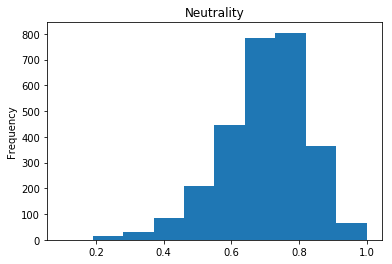

In [99]:
import pylab as pl
from pandas import *

pscores = [sid.polarity_scores(comment) for comment in reviews_f]
pd.Series([score['neu'] for score in pscores]).plot(kind='hist')
pl.title("Neutrality")